In [1]:
import optax
import numpy as np
import jax
import jax.numpy as jnp
from flax import linen as nn
import matplotlib.pyplot as plt
import sys
import os

# Add /src to path
path_to_src = os.path.abspath(os.path.join(os.getcwd(), '../src'))
if path_to_src not in sys.path:
    sys.path.append(path_to_src)
from sklearn.model_selection import train_test_split
from KAN import KAN

%load_ext autoreload
%autoreload 2

In [2]:
# Initialize model
key = jax.random.PRNGKey(232)

layer_dims = [1, 3, 2, 1]
model = KAN(layer_dims=layer_dims, k=3, const_spl=False, const_res=False, add_bias=True, grid_e=0.02)
variables = model.init(key, jnp.ones([1, 1]))

Platform 'METAL' is experimental and not all JAX functionality may be correctly supported!
W0000 00:00:1716306349.829327 8927691 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1716306349.855536 8927691 service.cc:145] XLA service 0x147d9a130 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716306349.855549 8927691 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1716306349.858280 8927691 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1716306349.858297 8927691 mps_client.cc:384] XLA backend will use up to 11452858368 bytes on device 0 for SimpleAllocator.


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [3]:
tabulate_fn=nn.tabulate(model, jax.random.PRNGKey(11))
tt = jnp.linspace(0,3,5).reshape(-1,1)
table=tabulate_fn(tt)
print(table)


                                  KAN Summary                                   
┏━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ path     ┃ module   ┃ inputs      ┃ outputs     ┃ params       ┃ state       ┃
┡━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│          │ KAN      │ float32[5,… │ -           │ bias_0:      │             │
│          │          │             │ float32[5,… │ float32[3]   │             │
│          │          │             │ - -         │ bias_1:      │             │
│          │          │             │ float32[3,… │ float32[2]   │             │
│          │          │             │   -         │ bias_2:      │             │
│          │          │             │ float32[2,… │ float32[1]   │             │
│          │          │             │   -         │              │             │
│          │          │             │ float32[1,… │ 6 (24 B)     │             │
├──────────┼──────────┼────

In [4]:
def _grad(f, idx, order=1):
    """
    Compute the higher order gradient of f with respect to the idx-th column of the input.
    """
    def grad_fn(g, idx):
        return lambda tx: jax.grad(lambda tx: jnp.sum(g(tx)))(tx)[..., idx].reshape(-1,1)

    g = lambda tx: f(tx)
    for _ in range(order):
        g = grad_fn(g, idx)

    return g


def create_los_mean(losses, datas, sigmas):
    @jax.jit
    def L(params, collocs, W):
        los=0.0
        for loss, colloc, data, sigma, w in zip(losses, collocs, datas, sigmas, W):
            los+=w*jnp.mean(loss(params, colloc, data, sigma))
        return los

    @jax.jit
    def L_no_W(params, collocs):
        los=[]
        for loss, colloc, data, sigma in zip(losses, collocs, datas, sigmas):
            los.append(jnp.mean(loss(params, colloc, data, sigma)))
        return jnp.array(los)
    @jax.jit
    def L_W(params, collocs,W):
        los=[]
        for loss, colloc, data, sigma, w in zip(losses, collocs, datas, sigmas, W):
            los.append(w*jnp.mean(loss(params, colloc, data, sigma)))
        return jnp.array(los)
    return L,L_no_W,L_W

m=1.0
k=1.0
def physics(params,colloc):
  def x(t): return model.apply(params,t)[0]
  ddx = _grad(x,0,2)
  return m*ddx(colloc)+k*x(colloc)

def physics_grad(params,colloc):
    def x(t): return model.apply(params,t)[0]
    ddx = _grad(x,0,2)
    def eq(t): return m*ddx(t)+k*x(t)
    deq = _grad(eq,0,1)
    return deq(colloc)

def physics_loss(params,colloc,data,sigma):
    #def sigma(t): return model.apply(params,t)[1]
    #sigma=params['params']['sigma']
    return physics(params,colloc)**2

def position_data_loss(params,colloc,data,sigma):
    def x(t): return model.apply(params,t)[0]
    return  (x(colloc)-data)**2

def velocity_data_loss(params,colloc,data,sigma):
    def x(t): return model.apply(params,t)[0]
    dx = _grad(x,0,1)
    return  (dx(colloc)-data)**2

In [5]:
# Initial Physics
#colloc_physics = jnp.linspace(0,1.5*np.pi).reshape(-1,1)
# Data Points
BC_colloc = jnp.zeros(1).reshape(-1,1)
BC_data1 = jnp.ones(1).reshape(-1,1)
BC_data2 = jnp.zeros(1).reshape(-1,1)
BC_sigma1 = jnp.ones(1).reshape(-1,1) * 0.1
BC_sigma2 = jnp.ones(1).reshape(-1,1) * 0.1

In [6]:
Ncolloc = 128
train_lims=[0,2.4*np.pi]
val_lims=[2.4*np.pi,4*np.pi]
#colloc_physics_ = jnp.linspace(train_lims[0],train_lims[1],2*Ncolloc).reshape(-1,1)
#colloc_physics,colloc_physics_val= train_test_split(colloc_physics_,train_size=Ncolloc)

colloc_physics = jnp.linspace(train_lims[0],train_lims[1],Ncolloc).reshape(-1,1)
colloc_physics_val = jnp.linspace(val_lims[0],val_lims[1],Ncolloc).reshape(-1,1)

In [7]:
collocs = [colloc_physics, BC_colloc, BC_colloc, colloc_physics] #this will change inside training
collocs_val = collocs.copy(); collocs_val[0]=colloc_physics_val
datas = [None, BC_data1, BC_data2, None]
sigmas = [None, BC_sigma1, BC_sigma2, None]
names = ['Physics','Position 0', 'Velocity 0']

losses = [physics_loss, position_data_loss, velocity_data_loss]
W0= np.ones(len(losses))

In [8]:
L,L_no_W,L_W = create_los_mean(losses,datas,sigmas)

In [9]:
L(variables,collocs,W0)

Array(18.80172, dtype=float32)

In [10]:
@jax.jit
def smooth_state_transition(old_state, variables):

    # Copy old state
    adam_count, adam_mu, adam_nu = old_state[0].count, old_state[0].mu, old_state[0].nu

    # Try a zero count
    adam_count = jnp.array(0, dtype=jnp.int32)

    # Get all layer-related keys, so that we do not touch the other parameters
    layer_keys = {k for k in adam_mu.keys() if k.startswith('layers_')}
    
    for key in layer_keys:
        # Find the c_basis shape for this layer
        c_shape = variables['params'][key]['c_basis'].shape
        # Find the c_basis for this layer and initialize its mu to zero
        adam_mu[key]['c_basis'] = jnp.zeros(c_shape, dtype=jnp.float32)
        # Find the c_basis for this layer and initialize its nu to zero
        adam_nu[key]['c_basis'] = jnp.zeros(c_shape, dtype=jnp.float32)

    # Make new adam state
    adam_state = optax.ScaleByAdamState(adam_count, adam_mu, adam_nu)
    # Make new empty state
    empty_state = optax.EmptyState()
    # Make new total state
    new_state = (adam_state, empty_state)

    return new_state

In [13]:
learning_rate = 5e-4
steps = 8000
grid_upds = {0 : 3, 500: 5, 1500: 10, 3000: 50}
print_step =100 
plot_step = 500
optimizer = optax.adam(learning_rate=learning_rate)
opt_state = optimizer.init(variables)
losses_test=[]
losses_val=[]
W=W0
losses_train = np.zeros((steps,len(W)))

L,L_no_W,L_W = create_los_mean(losses,datas,sigmas)

#@jax.jit
def train_step(params, opt_state, collocs, W, state):
    
    loss, grads = jax.value_and_grad(L)(params, collocs, W, state)
    
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    
    new_variables = {'params': params, 'state': state}
    
    return new_variables, opt_state, loss

for step in range(steps):
        #print(collocs)
        # loss_val, grads = jax.value_and_grad(L)(params,collocs,W)

        # updates, opt_state = optimizer.update(grads, opt_state)
        # params = optax.apply_updates(params, updates)

        if step in grid_upds.keys():
                print(f"Epoch {step+1}: Performing grid update")
                # Get grid size
                G_new = grid_upds[step]
                # Perform the update
                updated_variables = model.apply(variables, colloc_physics, G_new, method=model.update_grids)
                variables = updated_variables.copy()
                # Re-initialize optimizer smoothly when using optax - Adam
                opt_state = smooth_state_transition(opt_state, variables)

        params, state = variables['params'], variables['state']
        variables, opt_state, loss = train_step(params, opt_state, collocs, W, state)

        val_loss = jnp.sum(L_no_W(variables,collocs_val))
        losses_train[step,:] = L_no_W(variables,collocs)
        #losses_test.append(test_loss)
        losses_val.append(val_loss)

        if step % print_step == 0:
                #comps = np.array(loss_components(params,colloc_physics,BC_colloc, BC_data1,BC_sigma1, BC_colloc,BC_data2,BC_sigma2))
                print(f"step {step}/{steps}:  Loss: {loss:.3E} ({np.array2string(losses_train[step,:],separator=',', formatter={'float_kind':lambda x: '%.2E' % x})}), val: {val_loss:.3f} | ({np.array2string(W,separator=',', formatter={'float_kind':lambda x: '%.2E' % x})})")


        if (step % plot_step ==0):
                fig = plt.figure(layout="constrained",figsize=(10,10))
                ax = fig.subplot_mosaic(
                [
                        ["loss", "test"],
                        ["sol", "p"],
                        ['res', 'ntk']
                ],
                )
                if step>0:
                        ax['loss'].plot(losses_train[:step,:],label=names)
                        ax['loss'].plot(np.sum(losses_train[:step,:],axis=1),linewidth=2, color='black',label='Loss')
                        ax['loss'].legend()

                        ax['test'].plot(losses_val,label='Validation loss')
                        ax['test'].plot(losses_test,label='Test loss')
                        ax['test'].legend()

                
                        ax['loss'].set(yscale='log',title='Train losses')
                        ax['test'].set(yscale='log',title="Validation and test")

                x=model.apply(params,colloc_physics)[0]
                ax['sol'].plot(colloc_physics,x.flatten(),'.',label="Train")

        #     x=model.apply(params,colloc_physics_test)
        #     ax['sol'].plot(colloc_physics_test,x.flatten(),'.',label='Test')

                x=model.apply(params,colloc_physics_val)[0]
                ax['sol'].plot(colloc_physics_val,x.flatten(),'.',label='Validation')

                true_sol_t=np.linspace(0,7*np.pi)
                true_sol=np.cos(true_sol_t)
                ax['sol'].plot(true_sol_t,true_sol,label="True solution")
                ax['sol'].legend()
                for (los,colloc,name,data,sigma) in zip(losses,collocs,names,datas,sigmas):
                        if name != 'Penalty':
                                _loss_points=los(params,colloc,data,sigma)
                                ax['res'].plot(colloc,_loss_points,'.',label=f"{name}^2 = {jnp.mean(_loss_points):.3f}")
                                if name == "Physics":
                                        ax['res'].axhline(np.quantile(_loss_points,q=[0.9]))

                ax['res'].set(title="Residuals")
                ax['res'].legend()

                # for p in trace_params:
                #         ax['p'].plot(params_log[p],label=p)
                ax['p'].set(title="Parameters")
                ax['p'].legend()

                plt.show()

Epoch 1: Performing grid update


NotImplementedError: MLIR translation rule for primitive 'eigh' not found for platform METAL

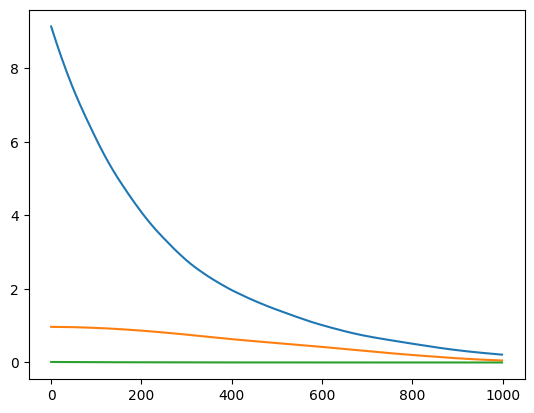

In [21]:
plt.plot(losses_train)

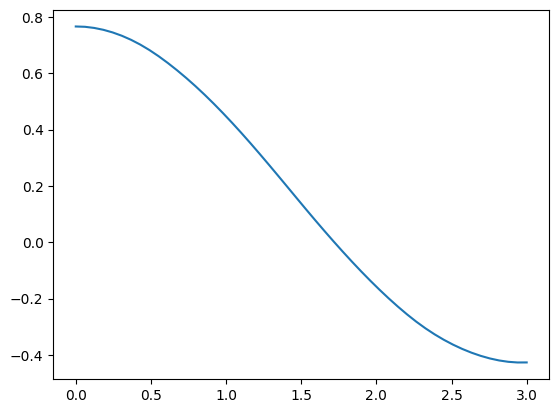

In [23]:
tt=jnp.linspace(0,3,50).reshape(-1,1)
plt.plot(tt, model.apply(params,tt)[0])